In [16]:
# imports 
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
from processing import *

# Data Preprocessing

## Visualise 2015 Data

In [3]:
# Load the river shapefile
river_map = gpd.read_file('../data/centerlines_data/ne_110m_rivers_lake_centerlines.shp')
brahmaputra = river_map[river_map['name'] == 'Brahmaputra']

river_linestring = brahmaputra.iloc[0]['geometry']
river_points = list(river_linestring.coords)
min(river_points), max(river_points)

((82.40047977084697, 30.411477362585146),
 (95.39648237506563, 28.002916368109368))

In [4]:
# Load 2015 data
path_2015 = '../data/yearly_discharge/discharge_2015.nc'
geo_2015 = loader(path_2015)
geo_2015.head()

Loaded data, converting to GeoDataFrame.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


GeoDataFrame loaded.


,time,lon,lat,dis24,geometry
0,2015-01-01,60.05,37.95,0.000119,POINT (60.05000 37.95000)
1,2015-01-01,60.05,37.85,0.001098,POINT (60.05000 37.85000)
2,2015-01-01,60.05,37.75,0.000071,POINT (60.05000 37.75000)
3,2015-01-01,60.05,37.65,0.000046,POINT (60.05000 37.65000)
4,2015-01-01,60.05,37.55,0.000217,POINT (60.05000 37.55000)


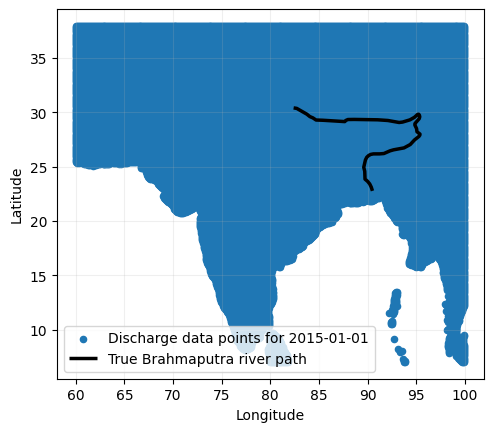

In [5]:
fig, ax = plt.subplots()

geo_2015[geo_2015['time']=='2015-01-01'].plot(ax=ax, markersize=20, marker='o', label='Discharge data points for 2015-01-01')
#geo_2015[geo_2015['time'] == '2015-01-01'].plot(ax=ax, markersize=20, marker='o', label='Discharge data points for 2015-01-01', c='discharge_column_name', cmap=plt.cm.Blues, legend=True)
brahmaputra.plot(ax=ax, color='k', label='True Brahmaputra river path', linewidth=2.5)

# later — colour points by discharge value

# plt.title('Discharge data points for 2015-01-01')
plt.legend(loc = 'lower left')
plt.grid(True, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('../images/all_data.png')
plt.show()

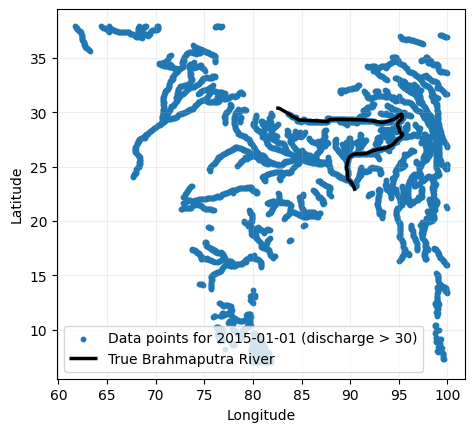

In [6]:
fig, ax = plt.subplots()

geo_2015[(geo_2015['time']=='2015-01-01') & (geo_2015['dis24'] > 30)].plot(ax=ax, markersize=10, marker='o', label='Data points for 2015-01-01 (discharge > 30)')
brahmaputra.plot(ax=ax, color='k', linewidth=2.5, label='True Brahmaputra River')

# plt.title('Discharge > 30 data points for 2015-01-01')
plt.legend(loc = 'lower left')
plt.grid(True, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('../images/regional_rivers.png')
plt.show()

add other rivers to the plot in another colour 

other features? 

In [ ]:
## do this to also check for second lat values (could reduce size of data)

((82.40047977084697, 30.411477362585146),
 (95.39648237506563, 28.002916368109368))

## Get closest points to river

In [11]:
# fig, ax = plt.subplots(figsize=(13, 6))

# brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)

# # geo_points['time'] = pd.to_datetime(geo_points['time'])
# # geo_points.plot(ax=ax, markersize=10, marker='o', label='Data Points Jan 2015')

# january_data = geo_points[(geo_points['time'].dt.month == 1)]
# january_data.plot(ax=ax, markersize=30, marker='o', label='Data Points Jan 2015')

# aug_data = geo_points[(geo_points['time'].dt.month == 8)]
# aug_data.plot(ax=ax, markersize=10, marker='x', color='m', label='Data Points Aug 2015')

# nov_data = geo_points[(geo_points['time'].dt.month == 11)]
# nov_data.plot(ax=ax, markersize=10, marker='x', color='g', label='Data Points Nov 2015')

# plt.grid(True)
# plt.legend()


# All Years

Loaded data, converting to GeoDataFrame.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


GeoDataFrame loaded.
Finished finding closest points, converting to geo.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


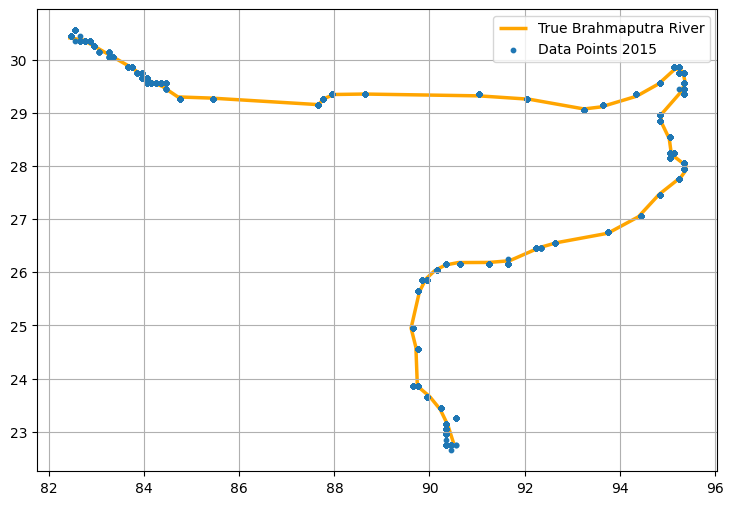

In [23]:
# Load 2015 data

data_2015 = loader('../data/yearly_discharge/discharge_2015.nc')
filtered_df_2015 = filter_relevant(data_2015)
geo_points_2015 = get_closest(filtered_df_2015, river_points, 3)
geo_points_2015 = remove_outliers(geo_points_2015)

# save
geo_points_2015.to_csv('../clean_data/cleaned_2015.csv', index=False)

# verify 
fig, ax = plt.subplots(figsize=(13, 6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)

geo_points_2015['time'] = pd.to_datetime(geo_points_2015['time'])
geo_points_2015.plot(ax=ax, markersize=10, marker='o', label='Data Points 2015')

plt.grid(True)
plt.legend()
plt.show()

Loaded data, converting to GeoDataFrame.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


GeoDataFrame loaded.
Finished finding closest points, converting to geo.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


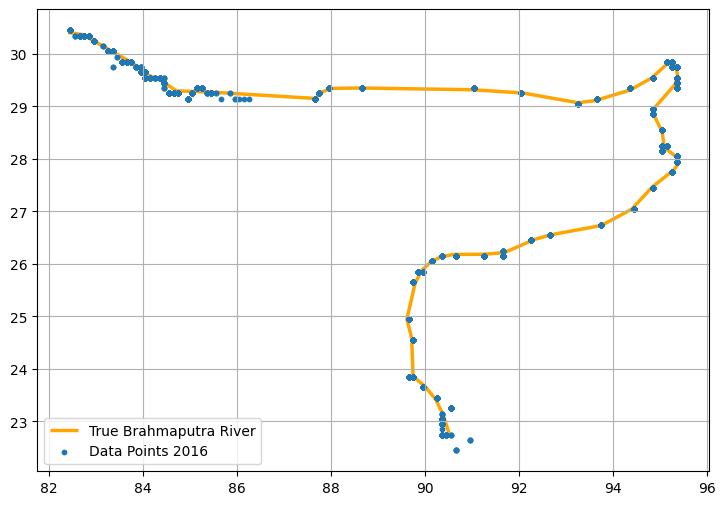

In [24]:
# Load 2016 data
data_2016 = loader('../data/yearly_discharge/discharge_2016.nc')
filtered_df_2016 = filter_relevant(data_2016)
geo_points_2016 = get_closest(filtered_df_2016, river_points, 3)
geo_points_2016 = remove_outliers(geo_points_2016)

# save
geo_points_2016.to_csv('../clean_data/cleaned_2016.csv', index=False)

# verify
fig, ax = plt.subplots(figsize=(13, 6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)

geo_points_2016['time'] = pd.to_datetime(geo_points_2016['time'])
geo_points_2016.plot(ax=ax, markersize=10, marker='o', label='Data Points 2016')

plt.grid(True)
plt.legend()
plt.show()

Loaded data, converting to GeoDataFrame.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


GeoDataFrame loaded.
Finished finding closest points, converting to geo.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


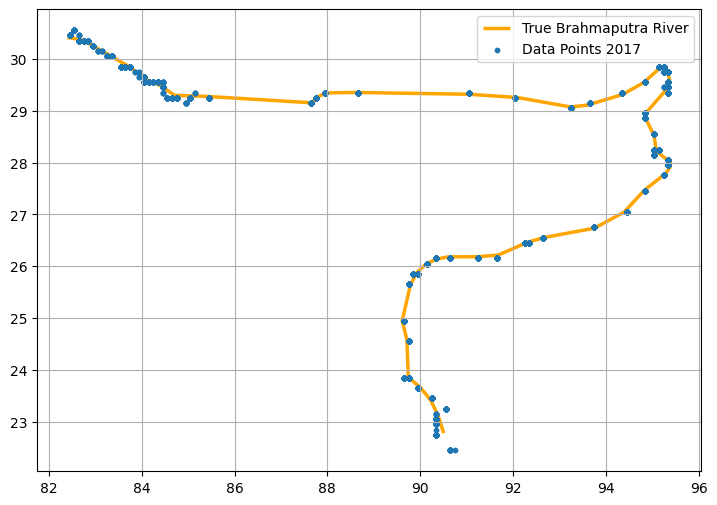

In [25]:
# Load 2017 data
data_2017 = loader('../data/yearly_discharge/discharge_2017.nc')
filtered_df_2017 = filter_relevant(data_2017)
geo_points_2017 = get_closest(filtered_df_2017, river_points, 3)
geo_points_2017 = remove_outliers(geo_points_2017)

# save
geo_points_2017.to_csv('../clean_data/cleaned_2017.csv', index=False)

# verify
fig, ax = plt.subplots(figsize=(13, 6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)

geo_points_2017['time'] = pd.to_datetime(geo_points_2017['time'])
geo_points_2017.plot(ax=ax, markersize=10, marker='o', label='Data Points 2017')

plt.grid(True)
plt.legend()
plt.show()

Loaded data, converting to GeoDataFrame.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


GeoDataFrame loaded.
Finished finding closest points, converting to geo.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


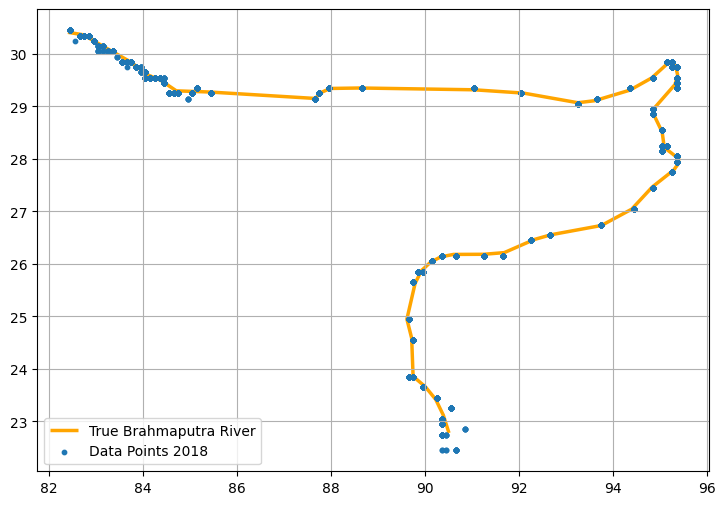

In [26]:
# Load 2018 data
data_2018 = loader('../data/yearly_discharge/discharge_2018.nc')
filtered_df_2018 = filter_relevant(data_2018)
geo_points_2018 = get_closest(filtered_df_2018, river_points, 3)
geo_points_2018 = remove_outliers(geo_points_2018)

# save
geo_points_2018.to_csv('../clean_data/cleaned_2018.csv', index=False)

# verify
fig, ax = plt.subplots(figsize=(13, 6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)

geo_points_2018['time'] = pd.to_datetime(geo_points_2018['time'])
geo_points_2018.plot(ax=ax, markersize=10, marker='o', label='Data Points 2018')

plt.grid(True)
plt.legend()
plt.show()

Loaded data, converting to GeoDataFrame.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


GeoDataFrame loaded.
Finished finding closest points, converting to geo.


/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


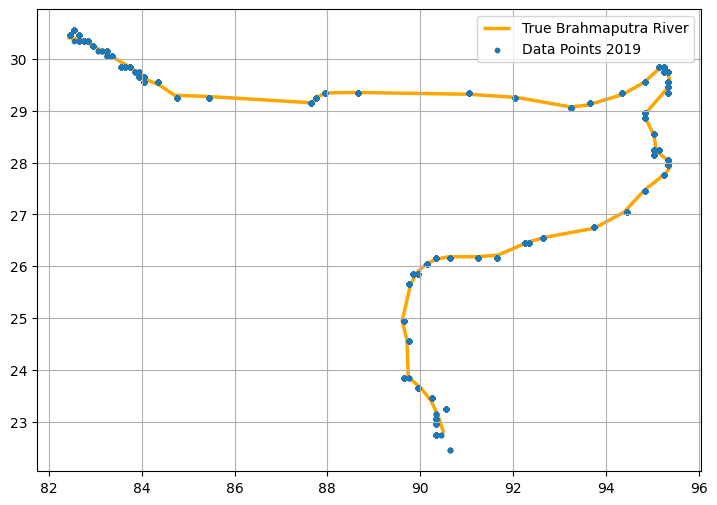

In [27]:
# Load 2019 data
data_2019 = loader('../data/yearly_discharge/discharge_2019.nc')
filtered_df_2019 = filter_relevant(data_2019)
geo_points_2019 = get_closest(filtered_df_2019, river_points, 3)
geo_points_2019 = remove_outliers(geo_points_2019)

# save
geo_points_2019.to_csv('../clean_data/cleaned_2019.csv', index=False)

# verify
fig, ax = plt.subplots(figsize=(13, 6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)

geo_points_2019['time'] = pd.to_datetime(geo_points_2019['time'])
geo_points_2019.plot(ax=ax, markersize=10, marker='o', label='Data Points 2019')

plt.grid(True)
plt.legend()
plt.show()

### Get only overlapping coords for all years

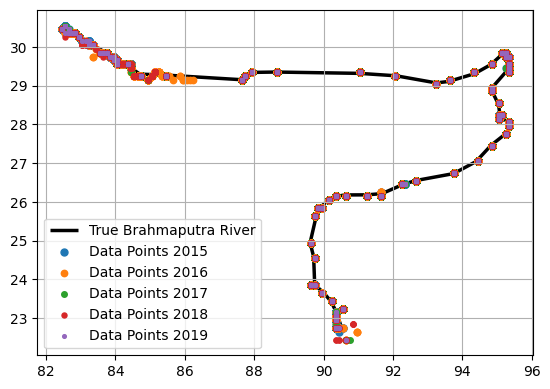

In [28]:
fig, ax = plt.subplots()

brahmaputra.plot(ax=ax, color='k', linewidth=2.5, label='True Brahmaputra River', zorder=0)

geo_points_2015.plot(ax=ax, markersize=25, marker='o', label='Data Points 2015')
geo_points_2016.plot(ax=ax, markersize=21, marker='o', label='Data Points 2016')
geo_points_2017.plot(ax=ax, markersize=16, marker='o', label='Data Points 2017')
geo_points_2018.plot(ax=ax, markersize=13, marker='o', label='Data Points 2018')
geo_points_2019.plot(ax=ax, markersize=7, marker='o', label='Data Points 2019')

plt.grid(True)
plt.legend()
plt.savefig('../images/good_data.png')
plt.show()

In [12]:
geo_points_2015 = pd.read_csv('../clean_data/cleaned_2015.csv')
geo_points_2016 = pd.read_csv('../clean_data/cleaned_2016.csv')
geo_points_2017 = pd.read_csv('../clean_data/cleaned_2017.csv')
geo_points_2018 = pd.read_csv('../clean_data/cleaned_2018.csv')
geo_points_2019 = pd.read_csv('../clean_data/cleaned_2019.csv')

In [29]:
all_coords = []

# Append the GeoSeries or GeoDataFrame of 'geometry' column of each dataframe to the list
for df in [geo_points_2015, geo_points_2016, geo_points_2017, geo_points_2018, geo_points_2019]:
    all_coords.append(df['geometry'])

# Compute the intersection of all GeoSeries
intersection = reduce(lambda x, y: x.intersection(y), all_coords)

# Filter each dataframe to keep only rows with coordinates in the intersection
overlapping_coords = []
for df in [geo_points_2015, geo_points_2016, geo_points_2017, geo_points_2018, geo_points_2019]:
    overlapping_coords.append(df[df['geometry'].isin(intersection)])

/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_50907/1748340563.py:8: UserWarning: The indices of the two GeoSeries are different.
  intersection = reduce(lambda x, y: x.intersection(y), all_coords)
/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_50907/1748340563.py:8: UserWarning: The indices of the two GeoSeries are different.
  intersection = reduce(lambda x, y: x.intersection(y), all_coords)
/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_50907/1748340563.py:8: UserWarning: The indices of the two GeoSeries are different.
  intersection = reduce(lambda x, y: x.intersection(y), all_coords)
/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_50907/1748340563.py:8: UserWarning: The indices of the two GeoSeries are different.
  intersection = reduce(lambda x, y: x.intersection(y), all_coords)


(16473, 5)
(16046, 5)
(16286, 5)
(16384, 5)
(16828, 5)


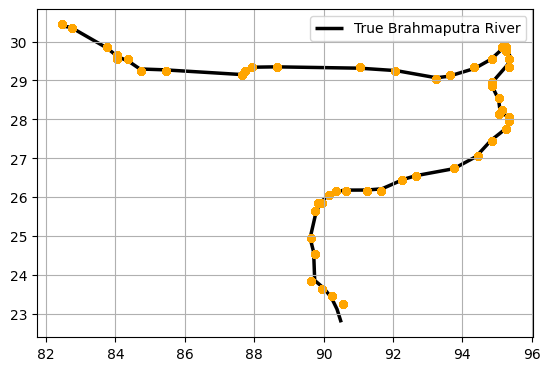

In [33]:
fig, ax = plt.subplots()
brahmaputra.plot(ax=ax, color='k', linewidth=2.5, label='True Brahmaputra River', zorder=0)

for df in overlapping_coords:

    print(df.shape)
    df.plot(ax=ax, markersize=25, marker='o', color='orange')

plt.grid(True)
plt.legend()
plt.savefig('../images/final_points.png')
plt.show()

In [ ]:
concatenated_df = pd.concat(overlapping_coords, ignore_index=True)
concatenated_df.to_csv('../clean_data/concatenated_data.csv', index=False)